In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
from pathlib import Path
from tqdm.notebook import tqdm
import os

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# Q1.1: Data Transformation

In [2]:
def round_time(time: str) -> str:
    """
    Round the time to the next hour.
    This function takes a time string in the format "HH:MM" and rounds it to the next hour.
    For example, "12:15" will be rounded to "13:00", and "12:00" will remain "12:00".
    Args:
        time (str): _description_

    Returns:
        str: _description_
    """
    data = time.split(":")
    hour = int(data[0])
    minute = int(data[1])
    hour = hour + 1 if minute > 0 else hour
    return f"{hour:02d}:00"

In [3]:
def add_missing_times(df):
    full_range = [f"{i:02d}:00" for i in range(49)] 
    
    # Create empty DataFrame with complete timeline
    full_df = pd.DataFrame({'Time': full_range})
    
    # Merge with original data
    merged = pd.merge(full_df, df, on='Time', how='left')
    
    return merged

In [4]:
# Create a dictionary to map the columns to their respective aggregation functions

d = {
    'Age': "last",
    'BUN': "max", 
    'Creatinine': "max", 
    'GCS': "min",
    'Gender': "last", 
    'Glucose': "max",  
    'HCO3': "min",
    'HCT': "min", 
    'HR': "max", 
    'Height': "last", 
    'ICUType': "last", 
    'K': "last", 
    'Mg': "last", 
    'NIDiasABP': "mean", 
    'NIMAP': "mean",
    'NISysABP': "mean", 
    'Na': "min", 
    'Platelets': "min", 
    'RecordID': "last", 
    'RespRate': "max", 
    'Temp': "max",
    'TroponinT': "max", 
    'Urine': "sum", 
    'WBC': "max", 
    'Weight': "last", 
    'ALP': "max", 
    'ALT': "max", 
    'AST': "max", 
    'Albumin': "min",
    'Bilirubin': "max", 
    'FiO2': "last", 
    'MechVent': "last", 
    'PaCO2': "max", 
    'PaO2': "max", 
    'pH': "min", 
    'DiasABP': "mean",
    'MAP': "mean", 
    'SaO2': "min", 
    'SysABP': "mean", 
    'Lactate': "max", 
    'Cholesterol': "last", 
    'TroponinI': "max"
}

# Create a new list of columns in the desired order, i.e., first the static variables followed by the dynamic variables
static_variables = ["Time", "RecordID", "Age", "Gender", "Height", "Weight", "ICUType"]
new_order = static_variables + list(set(d.keys()).difference(set(static_variables)))

In [5]:
# For the three provided datasets we perfrorm the following steps: 
for _set in ["a", "b", "c"]:
    
    # hold the new dataframes in a list
    pivoted_list = []
    for file in Path(f'../ml4h_data/p1/set-{_set}').glob('*.txt'):
        
        #read each file into a dataframe
        df = pd.read_csv(file)
        
        # apply the rounding function to the Time column
        df["Time"] = df.Time.apply(round_time)
        
        # pivot the dataframe so that all variables are in columns and apply the aggregation functions
        pivoted = df.pivot_table(index='Time', columns='Parameter', values='Value', aggfunc=["sum", "mean", "last", "min", "max"]).reset_index()
        
        # rename the columns base on the aggregation functions
        pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
        pivoted = pivoted[["Time_"] + [f"{v}_{k}" for k, v in d.items() if f"{v}_{k}" in pivoted.columns]]
        
        # remove the prefixes from the columns
        pivoted.columns = [col.split("_")[1] if col != "Time_" else col[:-1] for col in pivoted.columns]
        
        # add missing time rows
        pivoted = add_missing_times(pivoted)
        
        # add the RecordID
        pivoted['RecordID'] = pivoted['RecordID'].iloc[0]
        
        # save the pivoted dataframe into a list
        pivoted_list.append(pivoted)
        
    # concatenating all the pivoted dataframes into one
    dataset = pd.concat(pivoted_list).reset_index(drop=True)
    
    # simplify the RECORD ID values
    dataset["RecordID"] = dataset["RecordID"].astype(int)
    
    # apply the new order to the columns
    dataset = dataset[new_order]
    
    # add the outcome column
    outcomes = pd.read_csv(f"../ml4h_data/p1/Outcomes-{_set}.txt")
    outcomes = outcomes[["RecordID", "In-hospital_death"]]
    dataset = dataset.set_index("RecordID").join(outcomes.set_index("RecordID")).reset_index()
    
    # write the new dataset to a parquet file
    dataset.to_parquet(f"../data/set-{_set}.parquet", index=False)

# Q1.2 Exploratory Data Analysis

In [6]:
dataset_a = pd.read_parquet("../data/set-a.parquet")

<Axes: xlabel='In-hospital_death', ylabel='count'>

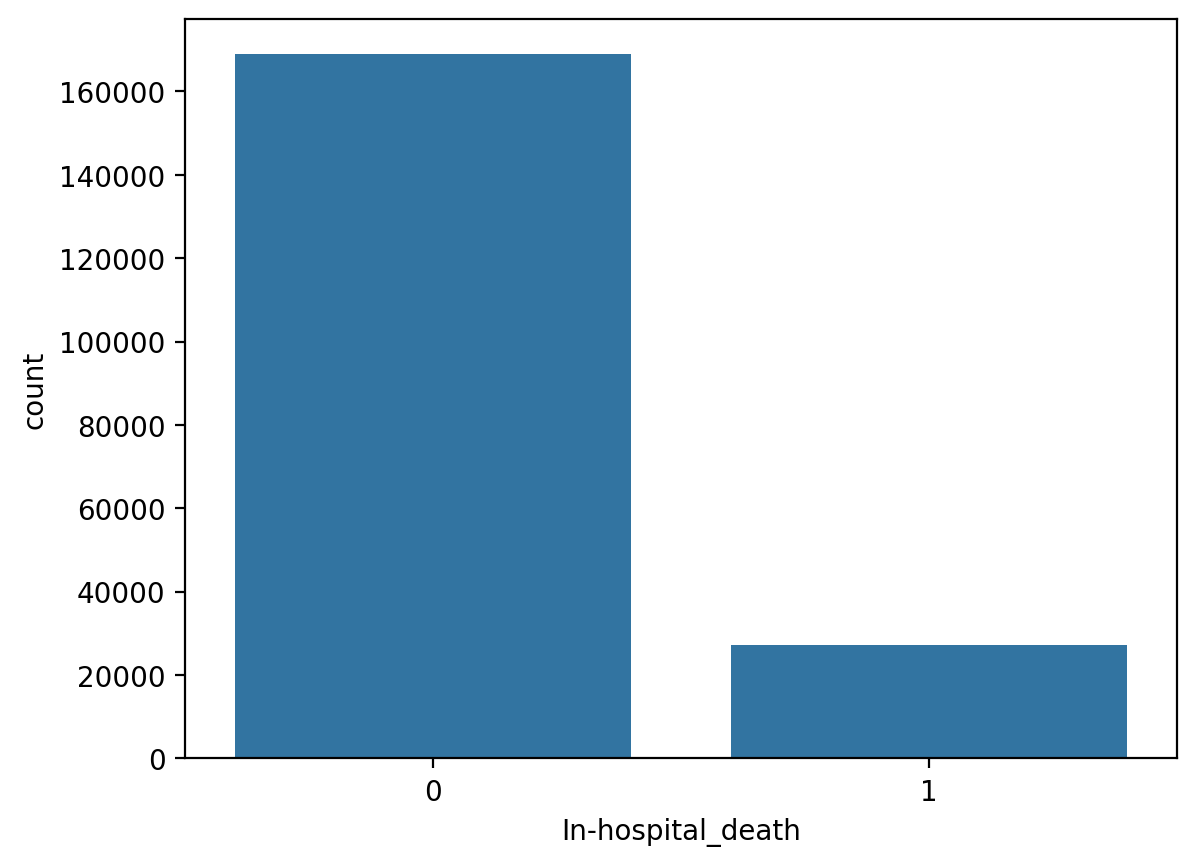

In [ ]:
sns.countplot(x="In-hospital_death", data=dataset_a)

# Q1.3 Preprocess data for Machine Learning

## Simple forward fill for the missing values

In [ ]:
train = pd.read_parquet("../data/set-a.parquet")
validation = pd.read_parquet("../data/set-b.parquet")
test = pd.read_parquet("../data/set-c.parquet")

- add the missing row when necassary so that every patient has the same number of rows
- perform the feedforward imputation 
- for the remaining values impute using the mean of the colmn

In [ ]:
filled_train = train.groupby('RecordID').ffill()
filled_train["RecordID"] = train.RecordID
filled_train

,Time,Age,Gender,Height,Weight,ICUType,HCT,HR,MechVent,WBC,...,Glucose,ALP,Lactate,Na,RespRate,Temp,SysABP,DiasABP,In-hospital_death,RecordID
0,00:00,61.0,1.0,152.4,86.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,136463
1,01:00,61.0,1.0,152.4,86.0,2.0,NaN,75.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,35.2,109.250000,56.00,0,136463
2,02:00,61.0,1.0,152.4,86.0,2.0,32.8,80.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,35.3,112.000000,58.25,0,136463
3,03:00,61.0,1.0,152.4,86.0,2.0,32.8,86.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,35.7,104.750000,54.50,0,136463
4,04:00,61.0,1.0,152.4,86.0,2.0,32.8,85.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,35.7,99.500000,63.25,0,136463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,49.0,1.0,182.9,105.0,2.0,25.6,57.0,1.0,12.8,...,117.0,NaN,0.9,134.0,NaN,36.9,159.666667,81.00,1,136897
195996,45:00,49.0,1.0,182.9,105.0,2.0,25.6,52.0,1.0,12.8,...,117.0,NaN,0.9,134.0,NaN,37.0,164.000000,84.00,1,136897
195997,46:00,49.0,1.0,182.9,105.0,2.0,25.6,54.0,1.0,12.8,...,117.0,NaN,0.9,134.0,NaN,37.0,165.000000,85.00,1,136897
195998,47:00,49.0,1.0,182.9,105.0,2.0,25.6,58.0,1.0,12.8,...,117.0,NaN,0.9,134.0,NaN,37.0,159.000000,77.00,1,136897


In [ ]:
numerical_features = filled_train.drop(columns=["RecordID", "Time", "Gender", "ICUType", "MechVent"])
numerical_features_mean = numerical_features.mean()

numerical_features.fillna(numerical_features_mean, inplace=True)
numerical_features[["RecordID", "Time", "Gender", "ICUType", "MechVent"]] = filled_train[["RecordID", "Time", "Gender", "ICUType", "MechVent"]]
filled_train = numerical_features.fillna(-1)
filled_train = filled_train[new_order +  ["In-hospital_death"]]
filled_train

,Time,RecordID,Age,Gender,Height,Weight,ICUType,HCT,HR,MechVent,...,NIMAP,Glucose,ALP,Lactate,Na,RespRate,Temp,SysABP,DiasABP,In-hospital_death
0,00:00,136463,61.0,1.0,152.4,86.0,2.0,31.583625,87.248902,-1.0,...,76.411843,136.79973,107.206897,2.206357,138.958957,19.877148,37.017982,118.078988,59.249764,0
1,01:00,136463,61.0,1.0,152.4,86.0,2.0,31.583625,75.000000,1.0,...,76.411843,136.79973,107.206897,2.206357,138.958957,19.877148,35.200000,109.250000,56.000000,0
2,02:00,136463,61.0,1.0,152.4,86.0,2.0,32.800000,80.000000,1.0,...,76.411843,136.79973,107.206897,2.206357,138.958957,19.877148,35.300000,112.000000,58.250000,0
3,03:00,136463,61.0,1.0,152.4,86.0,2.0,32.800000,86.000000,1.0,...,76.411843,136.79973,107.206897,2.206357,138.958957,19.877148,35.700000,104.750000,54.500000,0
4,04:00,136463,61.0,1.0,152.4,86.0,2.0,32.800000,85.000000,1.0,...,83.330000,136.79973,107.206897,2.206357,138.958957,19.877148,35.700000,99.500000,63.250000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,136897,49.0,1.0,182.9,105.0,2.0,25.600000,57.000000,1.0,...,76.411843,117.00000,107.206897,0.900000,134.000000,19.877148,36.900000,159.666667,81.000000,1
195996,45:00,136897,49.0,1.0,182.9,105.0,2.0,25.600000,52.000000,1.0,...,76.411843,117.00000,107.206897,0.900000,134.000000,19.877148,37.000000,164.000000,84.000000,1
195997,46:00,136897,49.0,1.0,182.9,105.0,2.0,25.600000,54.000000,1.0,...,76.411843,117.00000,107.206897,0.900000,134.000000,19.877148,37.000000,165.000000,85.000000,1
195998,47:00,136897,49.0,1.0,182.9,105.0,2.0,25.600000,58.000000,1.0,...,76.411843,117.00000,107.206897,0.900000,134.000000,19.877148,37.000000,159.000000,77.000000,1


In [ ]:
filled_train.to_parquet("../data/set-a-filled.parquet", index=False)

In [ ]:
filled_val = validation.groupby('RecordID').ffill()
filled_val["RecordID"] = validation.RecordID
filled_val

,Time,Age,Gender,Height,Weight,ICUType,HCT,HR,MechVent,WBC,...,Glucose,ALP,Lactate,Na,RespRate,Temp,SysABP,DiasABP,In-hospital_death,RecordID
0,00:00,67.0,1.0,-1.0,102.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,144801
1,01:00,67.0,1.0,-1.0,102.0,4.0,NaN,92.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,144801
2,02:00,67.0,1.0,-1.0,102.0,4.0,34.6,84.0,1.0,23.1,...,168.0,72.0,NaN,139.0,NaN,NaN,127.0,52.0,0,144801
3,03:00,67.0,1.0,-1.0,102.0,4.0,34.6,85.0,1.0,23.1,...,168.0,72.0,NaN,139.0,NaN,NaN,108.0,47.0,0,144801
4,04:00,67.0,1.0,-1.0,102.0,4.0,34.6,83.0,1.0,23.1,...,168.0,72.0,NaN,139.0,NaN,38.1,117.0,50.0,0,144801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,52.0,1.0,182.9,108.6,2.0,27.0,83.0,1.0,12.7,...,118.0,NaN,NaN,137.0,NaN,37.6,103.0,55.0,0,148029
195996,45:00,52.0,1.0,182.9,108.6,2.0,27.0,81.0,1.0,12.7,...,118.0,NaN,NaN,137.0,NaN,37.6,103.0,54.0,0,148029
195997,46:00,52.0,1.0,182.9,108.6,2.0,26.6,84.0,1.0,9.4,...,119.0,NaN,NaN,133.0,NaN,37.6,100.0,54.0,0,148029
195998,47:00,52.0,1.0,182.9,108.6,2.0,26.6,81.0,1.0,9.4,...,119.0,NaN,NaN,133.0,NaN,37.6,101.0,53.0,0,148029


In [ ]:
numerical_features = filled_val.drop(columns=["RecordID", "Time", "Gender", "ICUType", "MechVent"])

numerical_features.fillna(numerical_features_mean, inplace=True)
numerical_features[["RecordID", "Time", "Gender", "ICUType", "MechVent"]] = filled_val[["RecordID", "Time", "Gender", "ICUType", "MechVent"]]
filled_val = numerical_features.fillna(-1)
filled_val = filled_val[new_order +  ["In-hospital_death"]]
filled_val

,Time,RecordID,Age,Gender,Height,Weight,ICUType,HCT,HR,MechVent,...,NIMAP,Glucose,ALP,Lactate,Na,RespRate,Temp,SysABP,DiasABP,In-hospital_death
0,00:00,144801,67.0,1.0,-1.0,102.0,4.0,31.583625,87.248902,-1.0,...,76.411843,136.79973,107.206897,2.206357,138.958957,19.877148,37.017982,118.078988,59.249764,0
1,01:00,144801,67.0,1.0,-1.0,102.0,4.0,31.583625,92.000000,1.0,...,89.000000,136.79973,107.206897,2.206357,138.958957,19.877148,37.017982,118.078988,59.249764,0
2,02:00,144801,67.0,1.0,-1.0,102.0,4.0,34.600000,84.000000,1.0,...,77.000000,168.00000,72.000000,2.206357,139.000000,19.877148,37.017982,127.000000,52.000000,0
3,03:00,144801,67.0,1.0,-1.0,102.0,4.0,34.600000,85.000000,1.0,...,67.000000,168.00000,72.000000,2.206357,139.000000,19.877148,37.017982,108.000000,47.000000,0
4,04:00,144801,67.0,1.0,-1.0,102.0,4.0,34.600000,83.000000,1.0,...,75.000000,168.00000,72.000000,2.206357,139.000000,19.877148,38.100000,117.000000,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,148029,52.0,1.0,182.9,108.6,2.0,27.000000,83.000000,1.0,...,75.330000,118.00000,107.206897,2.206357,137.000000,19.877148,37.600000,103.000000,55.000000,0
195996,45:00,148029,52.0,1.0,182.9,108.6,2.0,27.000000,81.000000,1.0,...,71.000000,118.00000,107.206897,2.206357,137.000000,19.877148,37.600000,103.000000,54.000000,0
195997,46:00,148029,52.0,1.0,182.9,108.6,2.0,26.600000,84.000000,1.0,...,71.000000,119.00000,107.206897,2.206357,133.000000,19.877148,37.600000,100.000000,54.000000,0
195998,47:00,148029,52.0,1.0,182.9,108.6,2.0,26.600000,81.000000,1.0,...,71.000000,119.00000,107.206897,2.206357,133.000000,19.877148,37.600000,101.000000,53.000000,0


In [ ]:
filled_val.to_parquet("../data/set-b-filled.parquet", index=False)

In [ ]:
filled_test = test.groupby('RecordID').ffill()
filled_test["RecordID"] = test.RecordID
filled_test

,Time,Age,Gender,Height,Weight,ICUType,HCT,HR,MechVent,WBC,...,Glucose,ALP,Lactate,Na,RespRate,Temp,SysABP,DiasABP,In-hospital_death,RecordID
0,00:00,72.0,1.0,-1.0,60.6,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,156779
1,01:00,72.0,1.0,-1.0,60.6,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,156779
2,02:00,72.0,1.0,-1.0,60.6,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,156779
3,03:00,72.0,1.0,-1.0,60.6,4.0,NaN,59.0,NaN,NaN,...,NaN,NaN,NaN,NaN,19.0,36.5,136.0,58.5,0,156779
4,04:00,72.0,1.0,-1.0,60.6,4.0,NaN,60.0,NaN,NaN,...,129.0,NaN,NaN,154.0,14.0,36.5,137.0,57.0,0,156779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,27.0,1.0,-1.0,82.0,4.0,29.6,90.0,1.0,20.9,...,100.0,66.0,2.3,143.0,NaN,37.1,114.0,65.0,0,154592
195996,45:00,27.0,1.0,-1.0,82.0,4.0,29.6,100.0,1.0,20.9,...,100.0,66.0,2.3,143.0,NaN,37.1,144.0,98.0,0,154592
195997,46:00,27.0,1.0,-1.0,82.0,4.0,29.6,94.0,1.0,20.9,...,100.0,66.0,2.3,143.0,NaN,37.1,111.0,63.0,0,154592
195998,47:00,27.0,1.0,-1.0,82.0,4.0,29.6,96.0,1.0,20.9,...,100.0,66.0,2.3,143.0,NaN,37.1,119.0,69.0,0,154592


In [ ]:
numerical_features = filled_test.drop(columns=["RecordID", "Time", "Gender", "ICUType", "MechVent"])

numerical_features.fillna(numerical_features_mean, inplace=True)
numerical_features[["RecordID", "Time", "Gender", "ICUType", "MechVent"]] = filled_test[["RecordID", "Time", "Gender", "ICUType", "MechVent"]]
filled_test = numerical_features.fillna(-1)
filled_test = filled_test[new_order +  ["In-hospital_death"]]
filled_test

,Time,RecordID,Age,Gender,Height,Weight,ICUType,HCT,HR,MechVent,...,NIMAP,Glucose,ALP,Lactate,Na,RespRate,Temp,SysABP,DiasABP,In-hospital_death
0,00:00,156779,72.0,1.0,-1.0,60.6,4.0,31.583625,87.248902,-1.0,...,76.411843,136.79973,107.206897,2.206357,138.958957,19.877148,37.017982,118.078988,59.249764,0
1,01:00,156779,72.0,1.0,-1.0,60.6,4.0,31.583625,87.248902,-1.0,...,76.411843,136.79973,107.206897,2.206357,138.958957,19.877148,37.017982,118.078988,59.249764,0
2,02:00,156779,72.0,1.0,-1.0,60.6,4.0,31.583625,87.248902,-1.0,...,76.411843,136.79973,107.206897,2.206357,138.958957,19.877148,37.017982,118.078988,59.249764,0
3,03:00,156779,72.0,1.0,-1.0,60.6,4.0,31.583625,59.000000,-1.0,...,76.411843,136.79973,107.206897,2.206357,138.958957,19.000000,36.500000,136.000000,58.500000,0
4,04:00,156779,72.0,1.0,-1.0,60.6,4.0,31.583625,60.000000,-1.0,...,76.411843,129.00000,107.206897,2.206357,154.000000,14.000000,36.500000,137.000000,57.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,44:00,154592,27.0,1.0,-1.0,82.0,4.0,29.600000,90.000000,1.0,...,70.330000,100.00000,66.000000,2.300000,143.000000,19.877148,37.100000,114.000000,65.000000,0
195996,45:00,154592,27.0,1.0,-1.0,82.0,4.0,29.600000,100.000000,1.0,...,70.330000,100.00000,66.000000,2.300000,143.000000,19.877148,37.100000,144.000000,98.000000,0
195997,46:00,154592,27.0,1.0,-1.0,82.0,4.0,29.600000,94.000000,1.0,...,70.330000,100.00000,66.000000,2.300000,143.000000,19.877148,37.100000,111.000000,63.000000,0
195998,47:00,154592,27.0,1.0,-1.0,82.0,4.0,29.600000,96.000000,1.0,...,70.330000,100.00000,66.000000,2.300000,143.000000,19.877148,37.100000,119.000000,69.000000,0


In [ ]:
filled_test.to_parquet("../data/set-c-filled.parquet", index=False)

In [ ]:
# TODO: Data should be normalized after Q1.2